<a href="https://colab.research.google.com/github/the-menna-sherif/Refreshing_ML_Muscle_Memory/blob/main/Twitter_Disaster_Entry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Competition entry:

# Natural Language Processing with Disaster Tweets



In [3]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 53.7 MB/s eta 0:00:00


In [22]:
# Core Python & Utilities
import os
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# PyTorch (LLM / Transformers)
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    BertTokenizer,
    BertModel,
    get_linear_schedule_with_warmup
)
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# TensorFlow / Keras
import tensorflow as tf
import keras_nlp


# Scikit-learn (ML utilities & evaluation)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Loading data

In [5]:
# Fetching data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
submission_data = pd.read_csv('sample_submission.csv')

print('Training Set Shape = {}'.format(train_data.shape))
print('Test Set Shape = {}'.format(test_data.shape))

Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


In [5]:
train_data.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [6]:
# Number of unique entries per variable in train data
for col in train_data.columns:
    print('Variable name: {}\n Cardinality: {}, Data type: {}\n'.format(col, train_data[col].nunique(), train_data[col].dtype))

Variable name: id
 Cardinality: 7613, Data type: int64

Variable name: keyword
 Cardinality: 221, Data type: object

Variable name: location
 Cardinality: 3341, Data type: object

Variable name: text
 Cardinality: 7503, Data type: object

Variable name: target
 Cardinality: 2, Data type: int64



In [7]:
test_data.tail()

,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


In [7]:
# better function than loop used above :) !
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


**Initial data cleanup**

I will use random libraries on copies of the training data to *clean* the data. I will retain the most efficient and effective copies for my visualization & later, prediction.

---

Most NLP models break text into "tokens" (words or sub-words). Extra whitespaces can lead to "empty tokens" or "null tokens".

**Removing whitespaces** will ease model's digestion.

In [8]:
# Removes all extra whitespace and newlines in the text variables (tweet itself)
def remove_whitespaces(text):
  return " ".join(text.split())

# Test call
train_data_copy_no_whitespace = train_data.copy()
train_data_copy_no_whitespace['text']= train_data_copy_no_whitespace['text'].apply(remove_whitespaces)
train_data_copy_no_whitespace.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


---

**Dropping dupes**

This should prevent overfitting.

In [9]:
# Test call

def drop_dupes(df):
  train_data_copy_no_dupes = df.copy()

  train_data_copy_no_dupes = (
      train_data_copy_no_dupes
          .drop_duplicates(subset=['text'])
          .reset_index(drop=True)
  )

  # train_data_copy_no_dupes.head(10)
  return train_data_copy_no_dupes

**Visualizing the data**

I will use the seaborn & matplotlib libraries to inspect the data, and possibly do some feature engineering!

**Plan:**
1. Present features
2. Meta-features
3. Target

First, we check out the present features.

<Axes: >

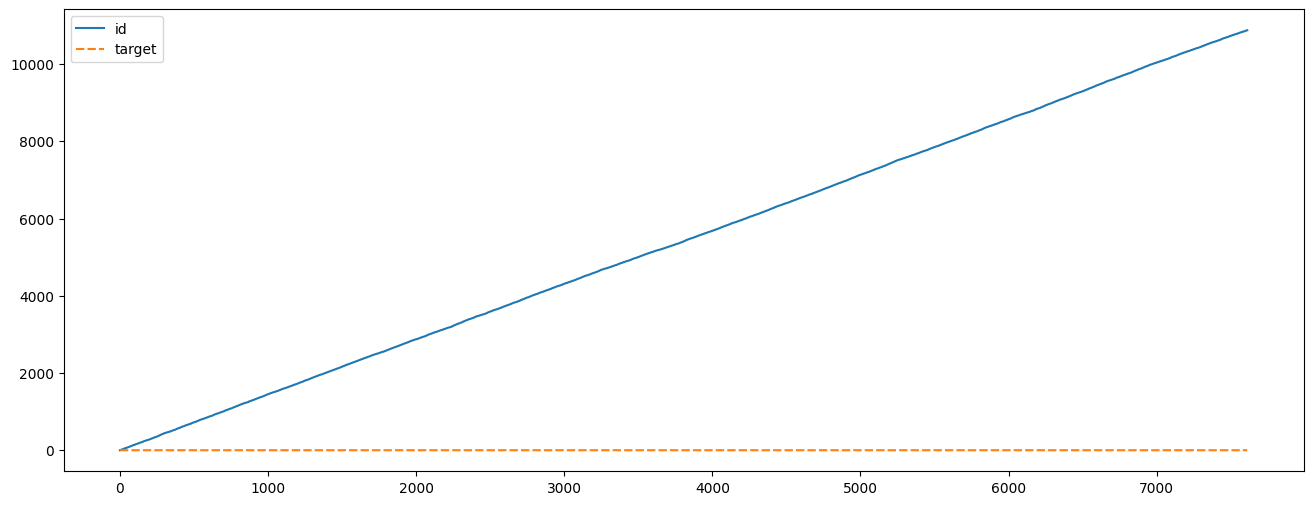

In [ ]:
# Set the width and height of the figure
plt.figure(figsize=(16,6))

sns.lineplot(data=train_data)

# Target analysis

In [10]:
# Ex Not Disaster Tweet
print("Not Disaster example: ", train_data[train_data["target"] == 0]["text"].values[1])

# Ex Disaster Tweet
print("Disaster example: ", train_data[train_data["target"] == 1]["text"].values[1])

Not Disaster example:  I love fruits
Disaster example:  Forest fire near La Ronge Sask. Canada


**Class distribution**

Classes are pretty closely distributed, as shown in cells below. No massive class imbalance. No stratification will be needed.

In [11]:
target_class_distribution = train_data['target'].value_counts(normalize=True) * 100
target_class_distribution

,proportion
target,
0,57.034021
1,42.965979


/tmp/ipython-input-1169170682.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Not Disaster', 'Disaster'])


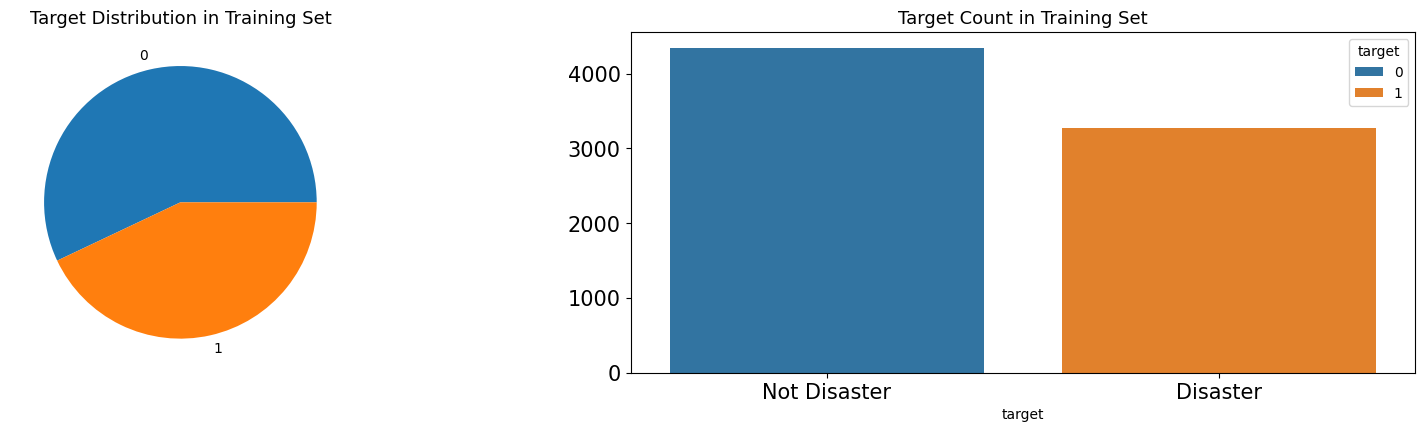

In [12]:
# Class distribution in Target looks

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train_data.groupby('target').count()['id'].plot(kind='pie', ax=axes[0])
sns.countplot(x=train_data['target'], hue=train_data['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster', 'Disaster'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

# Train/ Test Pipeline

In [14]:
# 1. Clean text (custom preprocessing)
train_data['text'] = train_data['text'].apply(remove_whitespaces)
test_data['text']  = test_data['text'].apply(remove_whitespaces)

# 2. Define DistilBERT preprocessor
preset = "bert_tiny_en_uncased"   # TinyBERT

# preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
#     preset,
#     sequence_length=160,
#     name="preprocessor_for_tweets"
# )


# 3. Define classifier
classifier = keras_nlp.models.BertClassifier.from_preset(
    preset,
    # preprocessor=preprocessor,
    num_classes=1   # single output neuron
)


# 4. Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    train_data['text'],  # cleaned text
    train_data['target'],
    test_size=0.2,
    random_state=42
)
# Convert labels to one-hot
# y_train = to_categorical(y_train, num_classes=2)
# y_val   = to_categorical(y_val, num_classes=2)

classifier.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)


# 5. Preprocess text into tensors
# X_train = preprocessor(X_train)
# X_val   = preprocessor(X_val)

# 6. Fit classifier
history = classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=2,
    validation_data=(X_val, y_val)
)

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.6874 - loss: 0.7312 - val_accuracy: 0.7866 - val_loss: 0.4915
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 493s 3s/step - accuracy: 0.7128 - loss: 0.5841 - val_accuracy: 0.7597 - val_loss: 0.5349


# Outputs & Visualization

In [33]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

def compute_metrics(y_true, y_pred):
    y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    # precision = precision_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)

    return {"accuracy": accuracy, "recall": recall, "f1": f1}


In [20]:
y_pred_val = classifier.predict(X_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 751ms/step


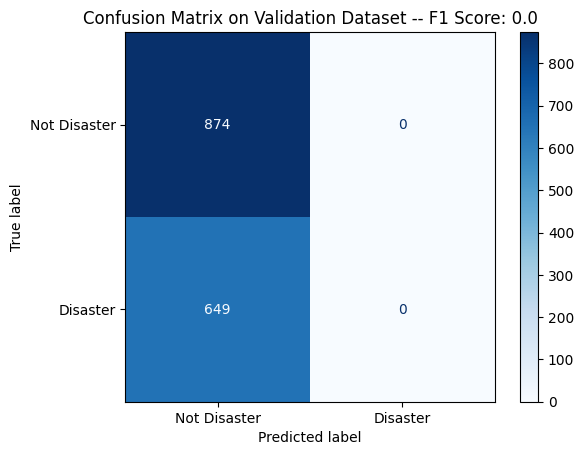

In [21]:
displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [34]:
compute_metrics(y_val, y_pred_val)

{'accuracy': 0.5738673670387393, 'recall': 0.0, 'f1': 0.0}

# Test set & submission

In [ ]:
print("Predicting on test set...")
predictions = classifier.predict(test_data)
preds = np.argmax(predictions.predictions, axis=-1)

submission_data['target'] = preds
submission_data.to_csv('submission.csv', index=False)
print("Submission saved successfully!")